In [1]:
# UNDER CONSTRUCTION

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim
import cv2 as cv
import tensorflow as tf

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
dat = np.load('Data/Cat-SFG-17-01-2020.npz')
dat.files

['nobj', 'listgal', 'flux1400sfg', 'sizesfg', 'randidx', 'e1', 'e2']

In [3]:
dat['listgal'].shape

(300, 96, 96)

In [4]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])

### Loading PSF & SFG

In [5]:
gal = dat['listgal'][0,:,:]
psf = galsim.Image(img1, copy=True).array

psf /= np.sum(psf)

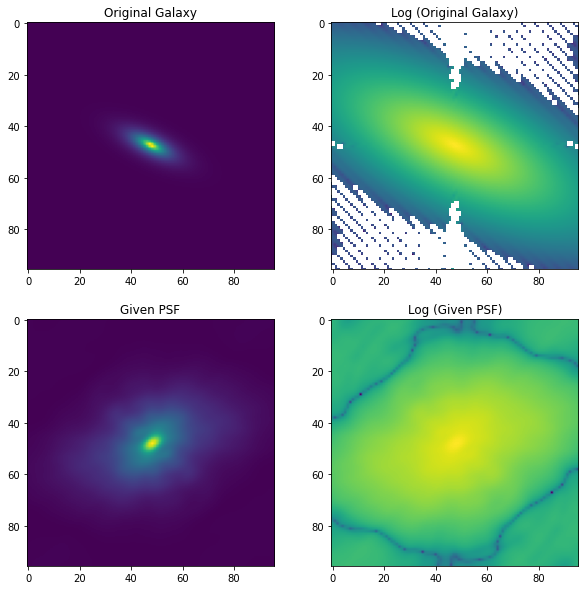

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(gal); ax1.set_title('Original Galaxy');
ax2.imshow(np.log10(gal)); ax2.set_title('Log (Original Galaxy)');
ax3.imshow(psf); ax3.set_title('Given PSF');
ax4.imshow(np.log10(psf)); ax4.set_title('Log (Given PSF)');

### FFT(Galaxy) + Gaussian Noise

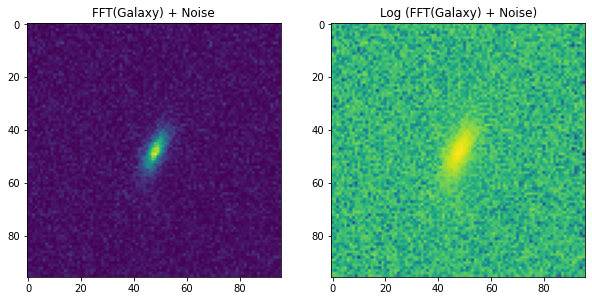

In [7]:
gal_fft = np.fft.fftshift(np.fft.fft2(gal))   
psf_fft = np.fft.fftshift(np.fft.fft2(psf))      

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 1.0e2                                                       # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_fft)/SNR                         # Standard deviation of noise

gal_fft_GSO = galsim.Image(gal_fft, copy=True)                    # Stored as GSO
gal_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(np.abs(gal_fft_GSO.array)); ax1.set_title('FFT(Galaxy) + Noise');
ax2.imshow(np.log10(np.abs(gal_fft_GSO.array))); ax2.set_title('Log (FFT(Galaxy) + Noise)');

### Convolve with PSF

(0.06832032443786301, 0.06832032443786301)

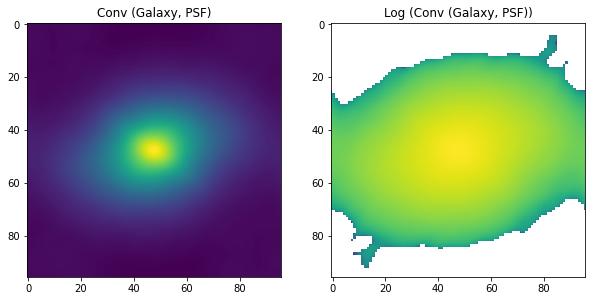

In [8]:
pad = 20        # Padding to remove aliasing

conv_padded = np.multiply(np.pad(gal_fft_GSO.array, pad), np.pad(psf_fft, pad))
conv = conv_padded[pad:conv_padded.shape[0]-pad, pad:conv_padded.shape[1]-pad]

final_gal = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(conv))))  # IFFT to get back to brightness domain
final_gal = final_gal * (np.sum(gal)/np.sum(final_gal))                     # Normalisation

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(final_gal); ax1.set_title('Conv (Galaxy, PSF)');
ax2.imshow(np.log10(final_gal)); ax2.set_title('Log (Conv (Galaxy, PSF))');

np.sum(gal), np.sum(final_gal)

# ADMM in TensorFlow

In [9]:
# Convert arrays to tensors

gal_tf = tf.convert_to_tensor(gal, dtype='complex64')
final_gal_tf = tf.convert_to_tensor(final_gal, dtype='complex64')
psf_tf = tf.convert_to_tensor(psf, dtype='complex64')

In [36]:
# Utility Functions

def fftconvolve(image, kernel):
   
    x = tf.signal.fftshift(tf.signal.fft2d(image))
    y = tf.signal.fftshift(tf.signal.fft2d(kernel))
    result = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(x * y))))

    return tf.cast(result, dtype='complex64')


def fft(data):

    return tf.math.multiply( tf.convert_to_tensor(1.0/data.shape[0], dtype='complex64'),  
                             tf.signal.fftshift(tf.signal.fft2d(tf.signal.ifftshift(data))) 
                           )


def ifft(data):

    return tf.math.multiply( tf.convert_to_tensor(data.shape[0], dtype='complex64'),
                             tf.signal.fftshift(tf.signal.ifft2d(tf.signal.ifftshift(data))) 
                           )


def soft_thresh(data, threshold):

    return tf.math.multiply( tf.cast(
                             tf.math.maximum( (tf.math.subtract(1.0, tf.math.divide(threshold, tf.math.abs(data)))), 0.0), 
                                               dtype='complex64'), data)


def nmse(signal_1, signal_2):

    return tf.math.divide(tf.math.pow(tf.norm(tf.math.subtract(signal_2, signal_1)), 2),  
                          tf.math.pow(tf.norm(signal_1), 2))

In [57]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(tf.cast(xi, dtype='float32'), 0.0), dtype='complex64')

 
def FISTA(tk, xk, x_rec, alpha, observation, psf, ST_lambda):

    x_temp = xk
    x_k1 = tf.math.subtract(x_rec, tf.math.multiply(alpha, grad(observation, x_rec, psf)))
    x_k1 = soft_thresh(x_k1, ST_lambda)
    xk = proj(x_k1)
    
    t_k1 = tf.math.add(tf.cast(1.0, dtype='complex64'), 
                       tf.math.divide(
                           tf.math.sqrt(
                               tf.math.add(tf.cast(1.0, dtype='complex64'), 
                                    tf.math.multiply(
                                        tf.cast(4.0, dtype='complex64'), tf.math.pow(tk, 2)))), 
                           tf.cast(2.0, dtype='complex64')))
    
    x_rec = tf.math.add(xk, tf.math.divide(tf.math.subtract(tk, tf.cast(1.0, dtype='complex64')), 
                                           tf.math.multiply(t_k1, tf.math.subtract(xk, x_temp))) )
    tk = t_k1
    return x_rec, tk, xk


# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return ifft(Ht(tf.math.subtract(H(fft(x_rec), psf), y), psf))


# The cost function
def cost_func(y, x_rec, z, mu, rho, psf, reg_lambda, var=1.0):

    cost_val = tf.math.add(tf.math.subtract(tf.math.multiply(tf.math.multiply(tf.cast(0.5, dtype='complex64'), rho), 
                                                             tf.math.pow(tf.norm(tf.math.subtract(z, x_rec)), 2)),
                                            tf.tensordot(mu, tf.math.subtract(z, x_rec), 1) ),
                           tf.math.multiply(tf.cast(0.5/var, dtype='complex64'), 
                                            tf.norm(tf.math.subtract(y, tf.math.pow(H(fft(x_rec), psf), 2)))) )

    return cost_val




def runADMM(observation, first_guess, psf, grad, z_0, mu_0, rho_0, rho_max, eta, gamma, delta_0,
            reg_lambda, ST_lambda, n_iter, alpha=1.0):
    
    cost = []
    nmse_arr = np.zeros(n_iter)
    x_opt = tf.zeros(tf.shape(observation.shape), dtype='complex64')
    count = 0
    
    # ADMM parameters
    x_k = first_guess
    z_k = z_0
    z_k1 = z_k
    mu_k = mu_0
    rho_k = rho_0         # Augmented lagrangian hyperparameter
    rho_k1 = rho_k
    delta_k = delta_0      
 
    # FISTA parameters
    tk = tf.cast(1.0, dtype='complex64')
    xk = first_guess
    
        
    for k in range(n_iter):
        
        # FISTA update
        x_rec, tk, xk = FISTA(tk, xk, x_k, alpha, observation, psf, ST_lambda)
        
        # Denoising -- CHECK 
        z_k1 = tf.math.add(x_rec, tf.math.divide(mu_k, rho_k))
        #z_k1 = cv.GaussianBlur(tf.math.abs(z_k1), (5,5), 0)      
        
        # mu update -- CHECK
        mu_k1 = tf.math.add(mu_k, tf.math.multiply(tf.math.subtract(x_rec, z_k1), rho_k))
    
        
        # Cost
        cost.append(cost_func(observation, x_rec, z_k1, mu_k1, rho_k, psf, reg_lambda))
        
        
        # Rho update
        delta_k1 = tf.math.multiply(tf.convert_to_tensor(1.0/final_gal_tf.shape[0], dtype='complex64'),
                                    tf.math.add(tf.math.add(tf.norm(tf.math.subtract(x_rec, x_k)), 
                                                            tf.norm(tf.math.subtract(z_k1, z_k)) ),
                                                tf.norm(tf.math.subtract(mu_k1, mu_k))) )
        
        if ( tf.math.greater_equal(tf.cast(delta_k1, dtype='float32'), 
                                   tf.cast(tf.math.multiply(eta, delta_k), dtype='float32')) and  
             tf.math.less(tf.cast(rho_k1, dtype='float32'), 
                          tf.cast(rho_max, dtype='float32')) ):
            
            rho_k1 = tf.math.multiply(gamma, rho_k)
            
        else:
            rho_k1 = rho_k  
        
        
        x_k = x_rec
        mu_k = mu_k1
        z_k = z_k1
        rho_k = rho_k1
                
        
        # Convert back to signal domain
        final_im = tf.math.abs(fft(x_rec))
        nmse_arr[k] = nmse(gal_tf, tf.cast(final_im, dtype='complex64'))
        
        
        if (k!=0) and (nmse_arr[k]<nmse_arr[k-1]) and count==0:
            x_opt = final_im
        elif (k!=0) and (nmse_arr[k]>nmse_arr[k-1]):
            count += 1
        
        
        if k%100==0 and k!=0:
            
            fig = plt.subplots(1,3, figsize=(25,25))
            
            plt.subplot(131)
            plt.title('Reconstruction after {} iterations'.format(k))
            ax1 = plt.gca()
            im1 = ax1.imshow(final_im)
            divider = make_axes_locatable(ax1)
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im1, cax=cax1)

            plt.subplot(132)
            plt.title('Log Scale Intensity')
            plt.imshow(np.log10(final_im))

            plt.subplot(133)
            plt.title('Intensity Plot (Central Slice)')
            ax3 = plt.gca()
            ax3.plot(final_im[48,:], label='rec_im')           
            ax3.plot(gal_tf[48,:], label='gal')  
            plt.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio())
            
            plt.show(fig)
    
    return final_im, x_opt, nmse_arr, cost

/Users/ua264756/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:978: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-p

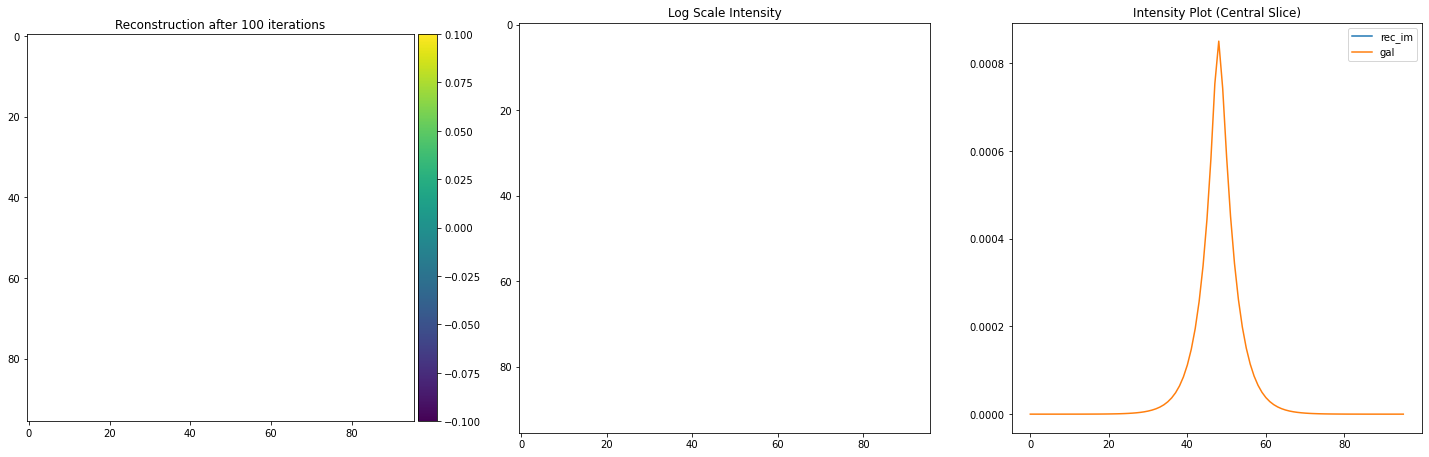

/Users/ua264756/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:978: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-p

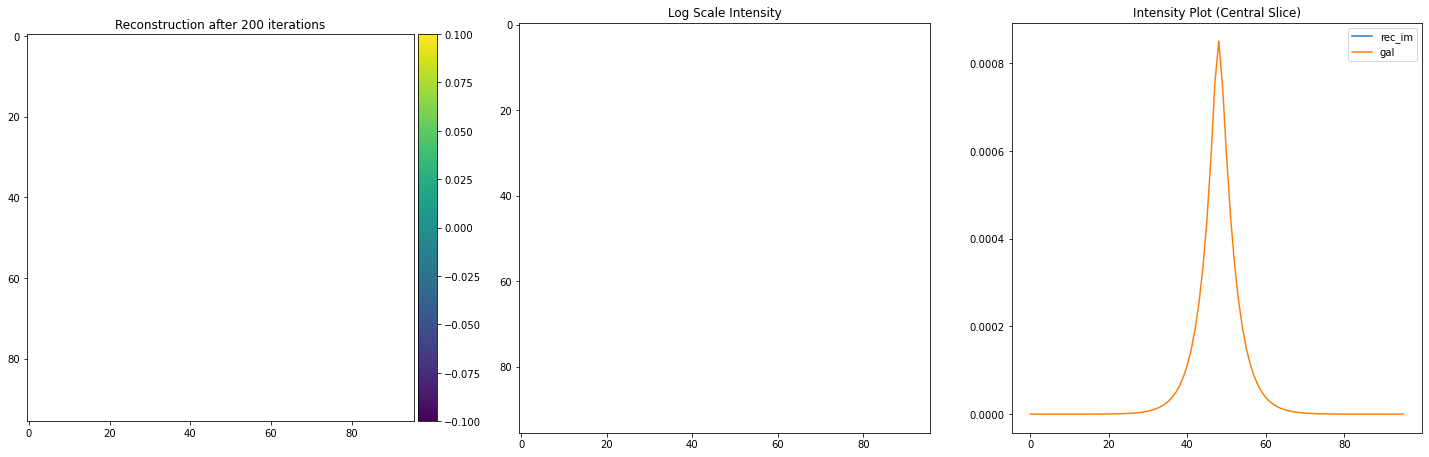

/Users/ua264756/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:978: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-p

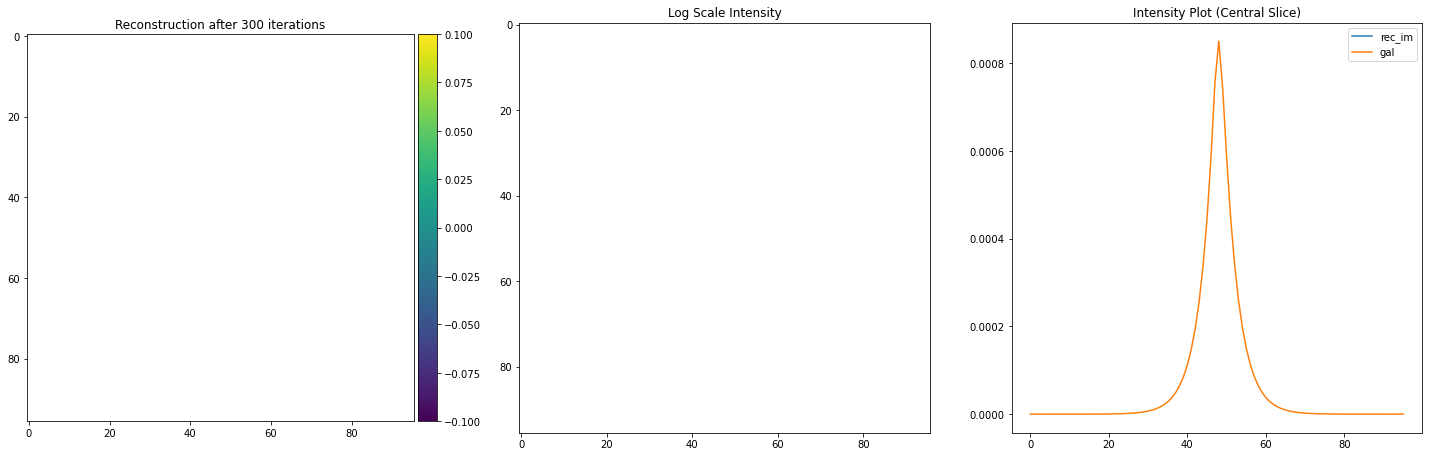

/Users/ua264756/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:978: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-p

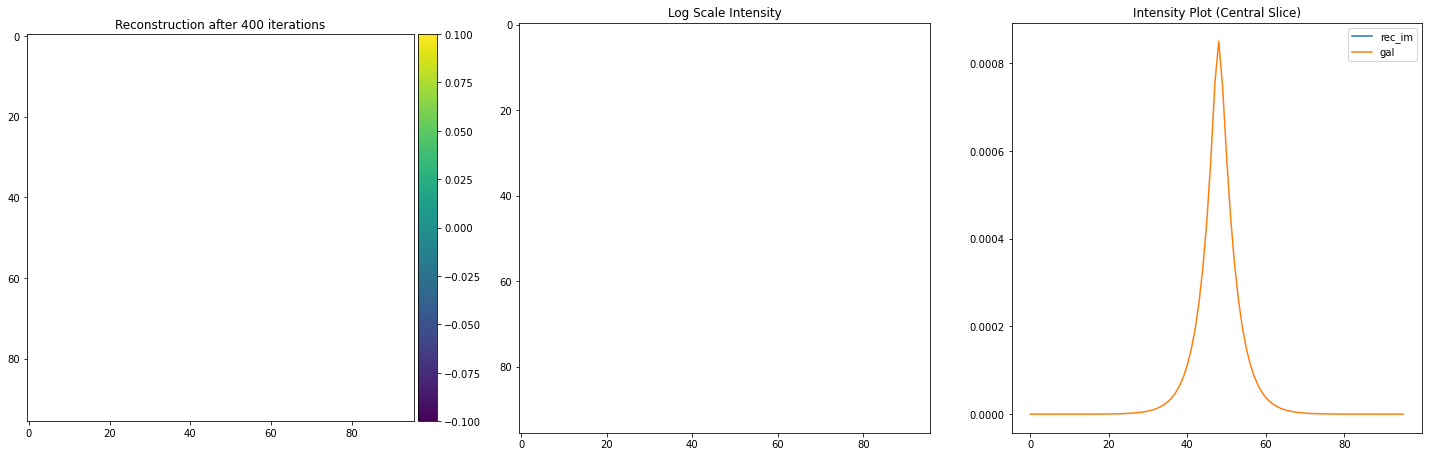

/Users/ua264756/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:978: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/ua264756/opt/anaconda3/lib/python3.8/site-p

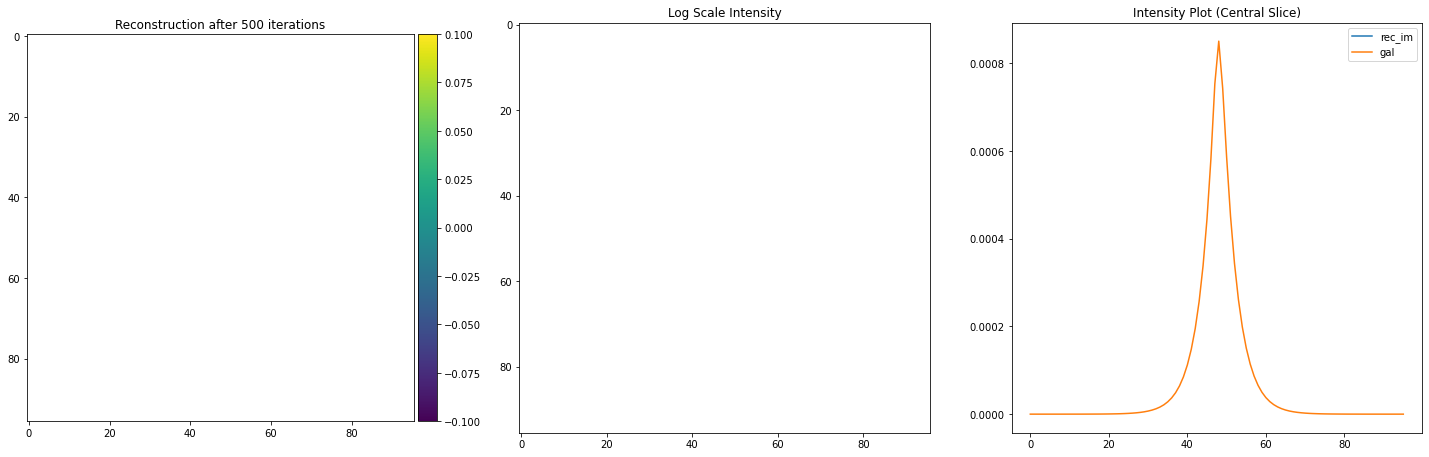

/Users/ua264756/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:978: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


In [58]:
n_iter = 600

# ADMM parameters (initial)
z_0 = tf.cast(0.0, dtype='complex64')
mu_0 = tf.cast(0.0, dtype='complex64')
rho_0 = tf.cast(50.0, dtype='complex64')         # Augmented lagrangian hyperparameter
rho_max = tf.cast(200.0, dtype='complex64')      # max rho value
eta = tf.cast(0.5, dtype='complex64')            # should be between - [0, 1)
gamma = tf.cast(1.4, dtype='complex64')          # multiplicative rho factor -- Should be > 1
delta_0 = tf.cast(0.0, dtype='complex64')

first_guess = tf.zeros(tf.shape(final_gal_tf), dtype='complex64')


# Deconvolve the image
final_im, x_opt, nmse_arr, cost = runADMM(final_gal_tf, first_guess, psf_tf, grad, z_0, mu_0, rho_0, rho_max, 
                                          eta, gamma, delta_0, reg_lambda=1e-4, ST_lambda=1e-9, n_iter=n_iter)

In [ ]:
# Comparison

temp = tf.concat([x_opt, gal_tf], 1)

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

ax1 = plt.subplot(gs[0])
plt.title('Observation')
ax1 = plt.gca()
im1 = ax1.imshow(final_gal_tf)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

ax2 = plt.subplot(gs[1])
plt.title('Optimal Reconstruction vs. Ground Truth')
ax2.imshow(temp)
ax2 = plt.gca()
im2 = ax2.imshow(temp)
ax2.axis('off')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.tight_layout()


fig2 = plt.subplots(1,3, figsize=(22,22))
plt.subplot(131)
plt.title('Residual (Y - H*X_est)')
ax1 = plt.gca()
im1 = ax1.imshow(tf.math.subtract(final_gal_tf, fftconvolve(psf_tf, x_opt)))
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

plt.subplot(132)
plt.title('Log [FFT (Residual (Y - H*X_est))]')
ax2 = plt.gca()
im2 = ax2.imshow(tf.math.log(tf.math.abs(fft(tf.math.subtract(final_gal_tf, fftconvolve(psf_tf, x_opt))))))
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.subplot(133)
plt.title('Error (X_true - X_est)')
ax3 = plt.gca()
im3 = ax3.imshow(tf.math.subtract(x_opt - gal_tf))
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

plt.show(fig2)

In [ ]:
min_nmse = np.min(nmse_arr)
min_iter = np.where(nmse_arr == min_nmse)[0][0]

fig3, ax3 = plt.subplots(1,1, figsize=(16,6))
ax3.plot(np.arange(1,n_iter+1), nmse_arr); ax3.set_title('NMSE vs. # Iterations');
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show(fig3)
print('\nMinimum NMSE = {} (at {} iterations)'.format(min_nmse, min_iter))